In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import g, R
from scipy.integrate import solve_ivp
from typhon.physics import e_eq_water_mk as saturation_pressure

plt.rcParams.update({'font.size': 12})

### some constants
mr_water     = 0.01801528        # molecular mass of water
mr_dry       = 0.0289647         # molecular mass (per 1 mole) of dry air (M_r)                 
mr_ratio     = mr_water/mr_dry
rgas_dry     = R/mr_dry          # specific gas constant for dry air [J/Kg/K]      <-- used in ideal gas equation for hydrostsic rather than moist??
rgas_v       = R/mr_water        # specific gas constant for water
cp_dry       = 1004.9            # specific heat capacity (dry) air [J/Kg/K] (taken at 300K)   = 1.400*cv_dry 
cp_v         = 1864              # specific heat capacity of water vapour [J/Kg/K] (at 300K)l
latent_v     = 2437300           # specific latent heat of vapourisation of water [J/Kg]  (at 300K)
diffuse_v    = 2.42e-5           # water vapour diffusivity in dry air (at 300K) [m^2/s]
diffuse_heat = 2.2185e-5         # thermal diffusivity of heat in dry air (at 300K) [m^2/s]
rho_l        = 996.57            # density of water [kg/m^3] (at 300K)
### NOTE! temperature depedence of cp and latent_v ignored
### NOTE! Heat content of condensed water ignored

In [2]:
def rgas_moist(qv):
    '''calculate moist specific gas
    constant of moist air:
    rgas_moist ~ (1+0.6qv)rgas_dry'''
    
    mfac = (1+qv*rgas_v/rgas_dry)/(1+qv)         # moist correction factor due to water vapour content of air
    
    return rgas_dry * mfac
    
    
def cp_moist(qv):
    '''calculate specific heat capacity of
    moist air: cp_moist ~ (1+0.9qv)cp_dry'''
    
    mfac = (1+qv*cp_v/cp_dry)/(1+qv)
    
    return cp_dry * mfac


def moist_rho(temp, p, qv):
    ''' calculte density of moist parcel 
    (unsaturated ie.
    excluding liquid water content) '''
   
    mfac =  (1+qv)/(1+qv/mr_ratio)
    
    return p/(rgas_dry*temp) * mfac


def pot_temp(temp, p, qv):
    ''' calculate potential temperature
    assuming moist (unsaturated) air with
    vapour content qv '''
    
    rgas = rgas_moist(qv)
    cp = cp_moist(qv)
    
    theta = temp*(p[0]/p)**(rgas/cp)
    
    return theta


#def saturation_pressure(temp):
#    '''empirical formuala for 
#    saturation pressure according to eq. 2.60
#    Lohmann intro to clouds'''
    
#    return  611.2 * np.exp(latent_v/rgas_v * (1/273.15 - 1/temp))

In [3]:
# surrouding profile
zg = 0
tempg = 273.15
pg = 100000
lps_rate = 0.0062

### initial parcel conditions
w               = 2                                             # vertical wind speed [m/s]
z0              = zg                                            # initial z coordinate
temp0, p0       = tempg, pg                                     # initial temp & pressure
relh0           = 80                                            # initial relative humidity (%)
qc0             = 0                                             # initial liquid water content
cond            = True

# integration params
tspan = [0,2500]
t_eval = np.linspace(tspan[0], tspan[1], 60)
maxtstep = 0.1


### resulting values of some variables
pv0 = relh0/100 * saturation_pressure(temp0)     # initial water vapour pressure
qv0 = mr_ratio * pv0/(p0-pv0)                    # initial water mass mixing ratio (mass water/mass dry air)


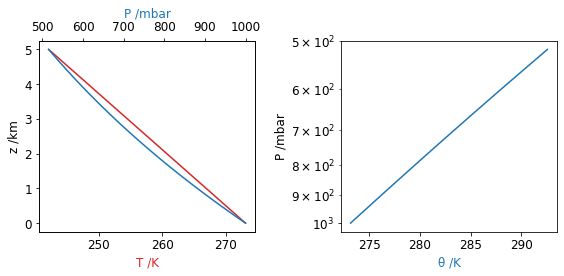

In [4]:
# surrounding air 
rgas_air = rgas_moist(qv0)      #assume surrounding air is moist but unsa
cp_air = cp_moist(qv0)

def surroudings_profile(z, tempg, zg, lps_rate):

    profile = 1 - lps_rate/tempg*(z-zg)
    temp_surr = tempg*profile
    p_surr = pg * profile**(g/(rgas_air*lps_rate))

    return temp_surr, p_surr


zplt = np.linspace(zg, zg+w*t_eval[-1], 100)
tempplt, pplt = surroudings_profile(zplt, tempg, zg, lps_rate)
thetaplt = pot_temp(tempplt, pplt, qv0) 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axs = axs.flatten()

def axplt(ax,x,y,xlab=None,ylab=None, lab=None, i=0):
    ax.plot(x,y, label=lab, color='C'+str(i))
    ax.set_xlabel(xlab, color='C'+str(i))
    ax.set_ylabel(ylab)

axs1 = axs[0].twiny()
axplt(axs[0], tempplt, zplt/1000, 'T /K', 'z /km', i=3)
axplt(axs1, pplt/100, zplt/1000,'P /mbar','z /km', i=0)
axplt(axs[1], thetaplt, pplt/100,'\u03B8 /K','P /mbar')
axs[1].set_yscale('log')
axs[1].invert_yaxis()

fig.tight_layout()
#plt.close()


In [5]:
class Superdroplets():
    '''Class for all superdroplets, 
    eg. for object drops = Superdroplets(r0) where r0
    is array of drop radii, drops is object with
    radii and masses of all superdroplets'''
    
   
    def __init__(self, r, eps, m_sol, mr_sol, ionic):
     
        # Common attributes of all superdroplets
        self.rho = 996.57                    # density of droplets (=density of water at 300K) [Kg/m^3]
       
        # droplet solute properties
        self.m_sol = m_sol                   # mass of solute dissovled [g]
        self.mr_sol = mr_sol                     # Mr of solute [g/mol]
        self.ionic = ionic                       # degree ionic dissociation (van't Hoff factor)

        # attributes unique to each sperdroplet object
        self.eps = eps                               # array of multiplicity of droplets
        self.r = r                                   # array of droplet radii
        self.r0 = r                                  # array of droplet radii
        self.m0 = self.rho*4/3*np.pi*(self.r)**3     # initial mass of droplet if it were all water

    @property
    def m(self):
        
        return self.rho*4/3*np.pi*(self.r)**3       # droplet total mass (water + solute)
    
    @property
    def m_water(self):
        
        mass_tot = self.rho*4/3*np.pi*(self.r)**3
        
        return mass_tot - self.m0                   # droplet water mass
        
    @property
    def vol(self):
        return 4/3*np.pi*(self.r)**3                # droplet volume
    


In [6]:

### ODE solver

def dtemp_adiabat(z, temp, p, qv, dz, temp_surr):
    ''' calculate dT/dt for adiabatic process
    of moist parcel (ignoring liquid water 
    content) via dT/dt = dz/dt * dT/dz = dz/dt * dT/dp * dp/dz.
    NOTE! assumes instanataneous volume change 
    of parcel to match pressure with that of 
    surrounding. Also assumes surroundings are dry and
    in hydrostatic equilibrium '''
    
    gamma = rgas_moist(qv)/cp_moist(qv)            # moist parcel constants
    dp_dz_p = -g/(rgas_air*temp_surr)              # 1/p_surr * dp/dz       
    dtemp = dz*gamma*temp*dp_dz_p                  # dT/dt = dz * (p * dT/dp) * (1/p_surr * dp/dz)
   
    # (redundant but useful) pressure evolution
    dp = w * dp_dz_p * p      
        
    return dtemp, dp


def diffusion_growth(drops, temp, p, qv):
    ''' diffusion growth of droplets by condensation
    given temperature, pressure and qv.
    NOTE! shrinking by evaporation not includeded, nor
    are ventillation effects fv(r) (see Seifert & stevens 2010)'''
    
    r = drops.r
    
    # supersaturation of parcel
    psat = saturation_pressure(temp)
    pv = qv*p/(mr_ratio + qv)                       
    qsat = mr_ratio * psat/(p-pv) 
    s = qv/qsat - 1                                
    
    if s > 0: 
        # diffusional growth equation factors
        thermk = 4.1868e-3 * (5.69 + 0.017*(temp-273.15))             #[eq.7.24 lohmann intro 2 clouds]
        diffuse_v = 2.11e-5 * (temp/273.15)**1.94 * (101325/p)        #[eq.7.26 lohmann intro 2 clouds]
        fkl = (latent_v/(rgas_v*temp) -1)*latent_v/(thermk*temp)
        fdl = rgas_v*temp/(diffuse_v*psat)
        
        # curvature and mass dissolved solute effects
        # r_activation = sqrt(3b/a), S_activation = 1+sqrt(4a^3/27b)
        a = 3.3e-7/temp                                               #2*surface_tens (=0.0756N/m)/(rho_l*rgas_v*temp) [eq.6.24]
        b = 43e-6*drops.m_sol*drops.ionic/drops.mr_sol                                  #43e-6 m^3/mol * mass_solute/ Mr_solute [eq.6.22]
        
        # radial growth of droplets
        #dr = s/(rho_l * (fkl+fdl) *r)                                  #[eq.7.27 lohmann intro 2 clouds]
        dr = (s -a/r +b/r**3) / (rho_l * (fkl+fdl) *r)                  #[eq.7.27 lohmann intro 2 clouds]

        # resultant change to temp, qv and qc of parcel
        dm = rho_l*4*np.pi*(drops.r**2)*dr                         # mass of water condsed onto each drop
        tot_drhov = np.sum(dm*drops.eps)                               # change in density of water in volume
        
        dqc = tot_drhov/moist_rho(temp, p, qv)
        dqv = -dqc
        dtemp_c = -latent_v/cp_moist(qv) * dqv
    
    else:
        dr = np.zeros(len(r))
        dtemp_c = 0
        dqv = 0
        dqc = 0
    
    return dr, dtemp_c, dqv, dqc


def rising_parcel(t, y, w, tempg, zg, 
                lps_rate, drops):
    ''' differential equations for rising parcel 
    (thermo)dynamics with condensation onto droplets
    if supersaturation > 0.
    Parcel rises, expands adiabatically and then
    condenses water if qv > q_sat. Rate of condensation
    determined by growth rate of droplets (supersaturation
    is possible if growth slower than rise in relative
    humidity)'''
    
    z, temp, p, qv, qc = y[:5]
    r = y[5:]
    
    drops.r = r
    
    ### dynamics of parcel
    #tau = 50*60                     # tau_w = 50min
    #dz = w*np.sin(2*np.pi*t/tau)
    dz = w
    
    ### thermodynamics of parcel
    # adiabatic expansion
    temp_surr, p_surr = surroudings_profile(z, tempg, zg, lps_rate)
    dtemp, dp = dtemp_adiabat(z, temp, p, qv, dz, temp_surr)
    
    # condensation (by diffusional growth of droplets)
    if cond:
        dr, dtemp_c, dqv, dqc = diffusion_growth(drops, 
                                temp, p, qv)
    else:
        dr = np.zeros(len(drops.r))
        dtemp_c, dqv, dqc = 0, 0, 0

    
    dtemp+=dtemp_c
    dy = [dz, dtemp, dp, dqv, dqc]
    dy.extend(list(dr))
    
    return dy

In [7]:
### ODE solution


#droplet properties
logr_edges = np.linspace(-8.91,-5.58,10)            # edges to lnr bins
del_logr = logr_edges[1:]-logr_edges[:-1]
logr = (logr_edges[1:]+logr_edges[:-1])/2  
r0 = 10**logr                                       # initial radii of all droplets in parcel

ndrops       = len(r0)                              # number of droplets per parcel volume
m_sol        = 1e-16                                # mass of solute dissovled [g]
mr_sol       = 58                                   # Mr of solute [g/mol]
ionic        = 2                                    # degree ionic dissociation (van't Hoff factor)
eps = np.full((ndrops), 1e8)                               # initial multiplicities of each radius drop (epsilons)

drops = Superdroplets(r0, eps, m_sol, mr_sol, ionic)        # drops = object of all droplets in parcel
args = [w, tempg, zg, lps_rate, drops]
y0 = [z0, temp0, p0, qv0, qc0]
y0.extend(list(drops.r))
sol = solve_ivp(rising_parcel, tspan, 
                y0, method='LSODA', t_eval=t_eval, args=args,
                   max_step=maxtstep)     

In [8]:
time = sol.t
z, temp, p, qv, qc = sol.y[:5]
r = sol.y[5:]
theta = pot_temp(temp, p, qv)
temp_surr, p_surr = surroudings_profile(z, tempg, zg, lps_rate)

print(z.shape, temp.shape, p.shape)
print(qv.shape, qc.shape, r.shape)

### other parcel thermodynamic variables
dry_adia = temp0*(p/p0)**(rgas_dry/cp_dry)
dry_adia_theta = dry_adia*(p0/p)**(rgas_dry/cp_dry)
pv = qv*p/(mr_ratio + qv) 
psat = saturation_pressure(temp)
relh = pv/psat
qsat = mr_ratio * psat/(p-pv) 
s = qv/qsat - 1        

(60,) (60,) (60,)
(60,) (60,) (9, 60)


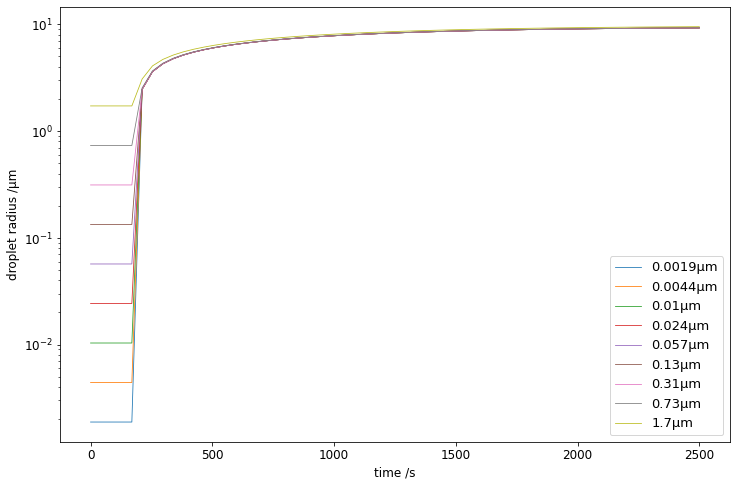

In [9]:
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(12,8))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in drops.r0]
for i in range(len(r)):
    ax.plot(time, r[i]*1e6, linewidth=0.8, label=labs[i])
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius /\u03BCm')
ax.set_yscale('log')
ax.legend(fontsize=13)

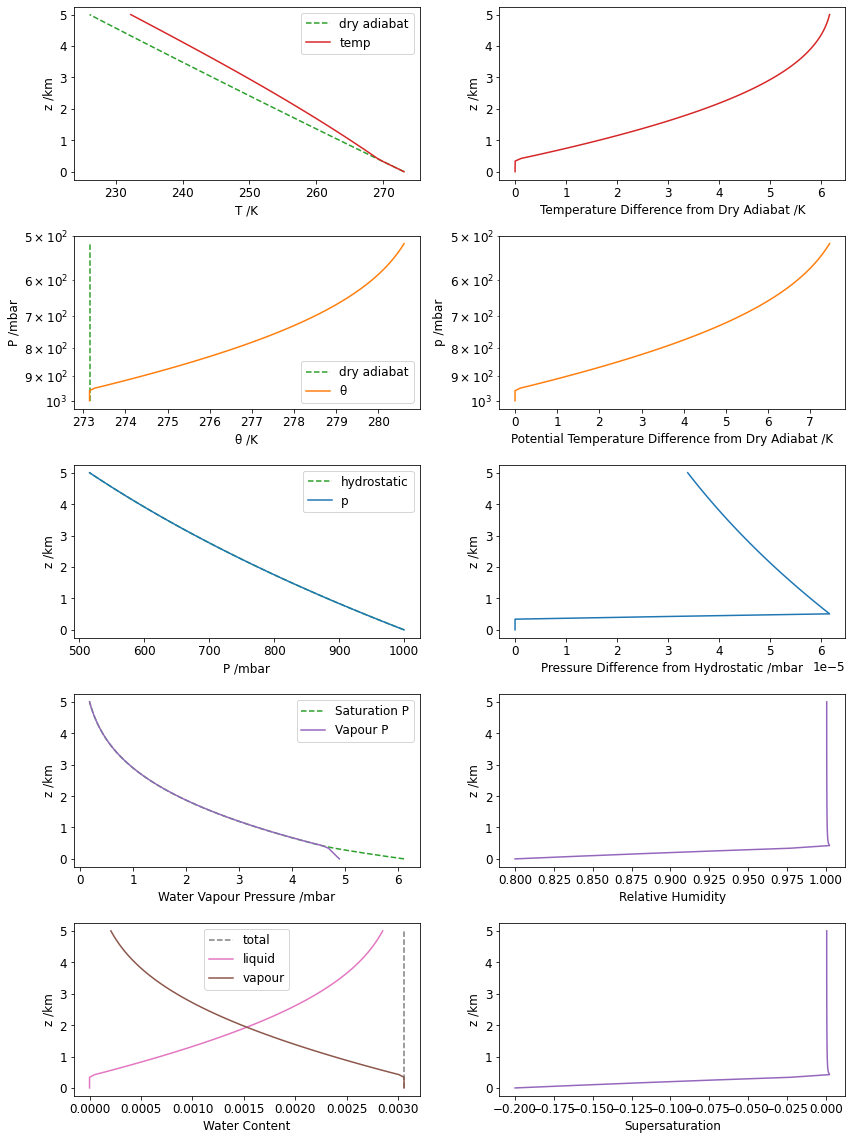

In [10]:
### plots of z, Temp, theta and pressure profiles

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,16))
axs = axs.flatten()

def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    ax.plot(x,y, label=lab, color='C'+str(c), linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axplt(axs[0], dry_adia, z/1000, lab='dry adiabat', c=2, l='--')
axplt(axs[4], p_surr/100, z/1000, lab='hydrostatic', c=2, l='--')
axplt(axs[2], dry_adia_theta, p/100, lab='dry adiabat', c=2, l='--')
axplt(axs[0], temp, z/1000, 'T /K', 'z /km', 'temp', 3)
axplt(axs[4], p/100,z/1000,'P /mbar','z /km', 'p', 0)
axplt(axs[2], theta, p/100,'\u03B8 /K','P /mbar', '\u03B8', 1)
axplt(axs[6], psat/100, z/1000,lab='Saturation P', c=2, l='--')
axplt(axs[6], pv/100, z/1000, 'Water Vapour Pressure /mbar','z /km', 'Vapour P', c=4)
axplt(axs[8], qv+qc, z/1000, lab='total', c=7, l='--')
axplt(axs[8], qc, z/1000, lab='liquid', c=6)
axplt(axs[8], qv, z/1000, 'Water Content','z /km', 'vapour', c=5)

axplt(axs[1], temp-dry_adia, z/1000, 'Temperature Difference from Dry Adiabat /K', 'z /km', c=3)
axplt(axs[5], (p-p_surr)/100, z/1000, 'Pressure Difference from Hydrostatic /mbar', 'z /km', c=0)
axplt(axs[3], (theta-dry_adia_theta), p/100, 'Potential Temperature Difference from Dry Adiabat /K', 'p /mbar', c=1)
axplt(axs[7], pv/psat, z/1000, 'Relative Humidity' ,'z /km', c=4)
axplt(axs[9], s, z/1000, 'Supersaturation' ,'z /km', c=4)

for ax in axs[::2]:
    ax.legend()
axs[2].set_yscale('log')
axs[2].invert_yaxis()
axs[3].set_yscale('log')
axs[3].invert_yaxis()


#psat = saturation_pressure(temp)
#axplt(axs[3], psat/100, z/1000,'saturation curve /mbar', 'z /km')

fig.tight_layout()
#plt.close()

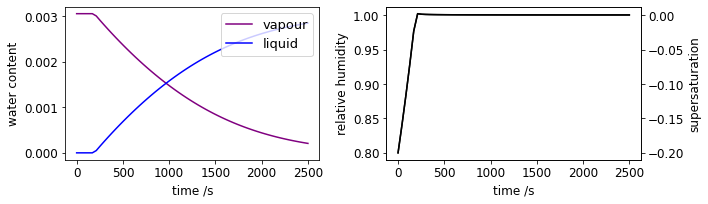

In [11]:
### plots of time evolution of water as parcel rises

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axs2 = axs[1].twinx()

axs[0].plot(time, qv, color='purple', label='vapour')
axs[0].plot(time, qc, color='blue', label='liquid')
axs[1].plot(time, relh, color='k')
axs2.plot(time, s, color='k')
axs[0].set_xlabel('time /s')
axs[0].set_ylabel('water content')
axs[1].set_xlabel('time /s')
axs[1].set_ylabel('relative humidity')
axs2.set_ylabel('supersaturation')
plt.tight_layout()
axs[0].legend(fontsize=13, loc='upper right')
plt.show()

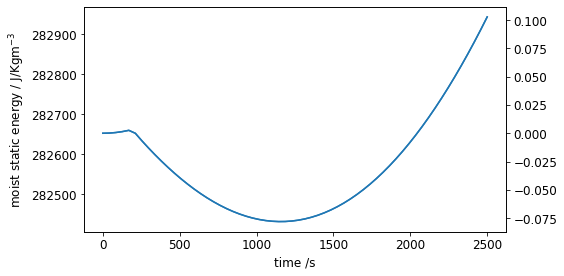

In [12]:
### Moist Static Energy Conservation

def moist_static_energy(z, temp, qv=0, dry=False):
    ''' calculate the moist static energy /m^3
        (not assuming dry air cp) '''
    
    if dry:
        return g*z + cp_moist(qv)*temp
    else:
        return  g*z + latent_v*qv + cp_moist(qv)*temp


mse = moist_static_energy(z, temp, qv)
#dse = moist_static_energy(z, temp, 0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(time, mse)
ax1 = ax.twinx()
ax1.plot(time, ((mse-mse[0])/mse[0]*100))
ax.set_ylabel('moist static energy / J/Kgm$^{-3}$')
axs1.set_ylabel('% change in moist static energy')
ax.set_xlabel('time /s')

plt.tight_layout()
plt.show()